In [ ]:
%load_ext autoreload
%autoreload 2

import os
import glob
import warnings
import re
from astropy.io import fits
from PIL import Image
import numpy as np
from DefectPixels import *

In [54]:
# Define user parameters
User_myFolder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images'
User_fits = 1
User_figures = r'C:\Users\Jill\Desktop\COSMOS Play\Matlab\Results'
User_save_figures = 1

# Check to make sure that folder actually exists. Warn user if it doesn't.
if not os.path.isdir(User_myFolder):
    error_message = f'Error: The following folder does not exist:\n{User_myFolder}'
    warnings.warn(error_message)
    raise FileNotFoundError(error_message)

# Function to find keywords in FITS header
def find_keywords(keywords, compare_word):
    indices = []
    for i, keyword in enumerate(keywords):
        if re.search(compare_word, keyword, re.IGNORECASE):
            indices.append(i)
    return indices

# Function to extract text between quotes
def extract_text_between_quotes(input_string):
    matches = re.findall(r'"([^"]*)"', input_string)
    if matches:
        return matches[0]
    else:
        return ''

# Initialize the stack list
stack = []

# Get a list of all files in the folder with the desired file name pattern.
if User_fits == 1:
    file_pattern = os.path.join(User_myFolder, '*.fits')
    the_files = glob.glob(file_pattern)

    for file in the_files:
        base_file_name = os.path.basename(file)
        full_file_name = os.path.join(User_myFolder, base_file_name)
        print(f'Now reading {full_file_name}')
        
        # Read FITS file
        hdul = fits.open(full_file_name)
        info = hdul.info()
        imagestack = hdul[0].data
        
        # Append to stack
        stack.append({
            'baseFileName': base_file_name,
            'fullFileName': full_file_name,
            'info': info,
            'imagestack': imagestack
        })
        
        # Close the FITS file
        hdul.close()
else:
    file_pattern = os.path.join(User_myFolder, '*.tif')
    the_files_tif = glob.glob(file_pattern)

    for file in the_files_tif:
        base_file_name = os.path.basename(file)
        full_file_name = os.path.join(User_myFolder, base_file_name)
        print(f'Now reading {full_file_name}')
        
        # Read TIFF file
        im = Image.open(full_file_name)
        imagestack = []
        try:
            while True:
                imagestack.append(np.array(im))
                im.seek(im.tell() + 1)
        except EOFError:
            pass
        
        imagestack = np.stack(imagestack, axis=-1)
        
        # Append to stack
        stack.append({
            'baseFileName': base_file_name,
            'fullFileName': full_file_name,
            'imagestack': imagestack
        })

# Keywords to find for COSMOS data
cosmoskeywords = ['DATE', 'DATE-OBS', 'BITPIX', 'SENSOR INFORMATION SENSORNAME', 'ACTIVEAREA HEIGHT', 'ACTIVEAREA WIDTH', 'ACTIVEAREA BOTTOMMARGIN',
                  'ACTIVEAREA LEFTMARGIN', 'ACTIVEAREA RIGHTMARGIN', 'PIXEL WIDTH', 'ADC BITDEPTH', 'ANALOGGAIN',
                  'ADC QUALITY', 'CORRECTPIXEL', 'FRAMERATE', 'FRAMESTOSTORE', 'BASEFILENAME', 'TEMPERATURE READING',
                  'READOUTCONTROL MODE', 'SHUTTERTIMING EXPOSURETIME']
fieldnames = ['date', 'time_stamp_acq', 'bit_per_pix', 'sensor_info', 'active_height', 'active_width', 'bottom_margin', 'leftmargin', 'rightmargin',
              'pixel_size_um', 'adc_bit', 'analog_gain', 'adc_speed', 'corrected', 'fps', 'frame_num', 'filename',
              'cam_temp_Cel', 'shutter', 'exposure_ms']

# Extract and store COSMOS keywords from FITS headers
for file_data in stack:
    if User_fits == 1:
        hdul = fits.open(file_data['fullFileName'])
        primary_header = hdul[0].header
        
        for keyword, fieldname in zip(cosmoskeywords, fieldnames):
            primary_keywords = list(primary_header.keys())
            primary_indices = find_keywords(primary_keywords, keyword)
            if primary_indices:
                index = primary_indices[0]
                extracted_text = primary_header[index]
                file_data[fieldname] = extracted_text
            else:
                file_data[fieldname] = None
        
        hdul.close()
    else:
        # Handle TIFF files if needed
        pass

# Display the stack dictionary
for file_data in stack:
    print(file_data)


Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images/test_darks.fits
Filename: /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images/test_darks.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     105   (8120, 8120, 50)   int16 (rescales to uint16)   


Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images/HighHighG_RS_raw_3400ms_SC_F5A 2024 May 07 12_18_43.fits
Filename: /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images/HighHighG_RS_raw_3400ms_SC_F5A 2024 May 07 12_18_43.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     105   (8120, 8120, 50)   int16 (rescales to uint16)   
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images/HighHighG_RS_raw_3400ms_SO_F5A 2024 May 07 12_15_15.fits
Filename: /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Software/Test images/HighHighG_RS_raw_3400ms_SO_F5A 2024 May 07 12_15_15.fits
No.    

In [55]:
medStackDark = np.median(stack[0]['imagestack'], axis=0)
medStackSC = np.median(stack[1]['imagestack'], axis=0)
medStackGray = np.median(stack[2]['imagestack'], axis=0)
print(np.median(medStackDark), np.median(medStackSC), np.median(medStackGray))

192.0 191.0 8444.0


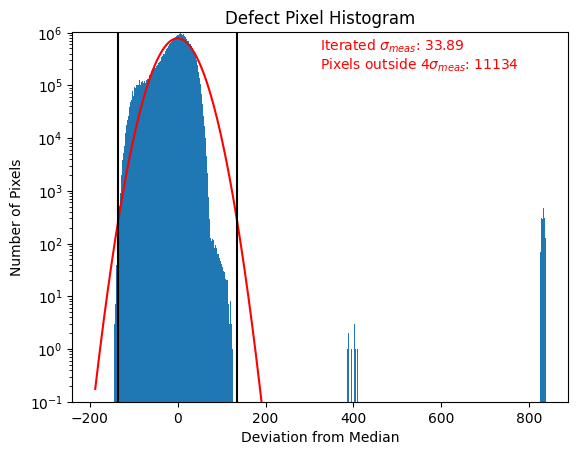

Number of NaNs in cleanArray: 11134


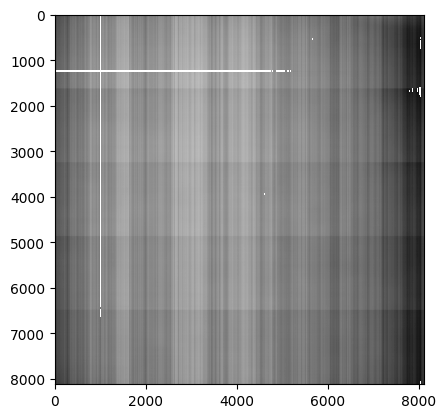

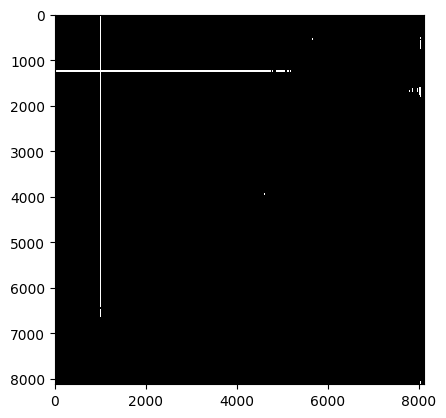

In [69]:
sigma_level = 4
plot_defect_hist(medStackDark, sigma_level=sigma_level, num_bins=1024)
defectMapDark, stdDark = defect_pix_map(medStackDark, sigma_level=sigma_level)
cleanArrayDark = medStackDark * defectMapDark
# count NaNs in cleanArray
nanCount = np.count_nonzero(np.isnan(cleanArrayDark))
print(f'Number of NaNs in cleanArray: {nanCount}')
plt.imshow(cleanArrayDark, cmap='gray')
plt.show()
plt.imshow(defectMapDark, cmap='gray')
plt.show()

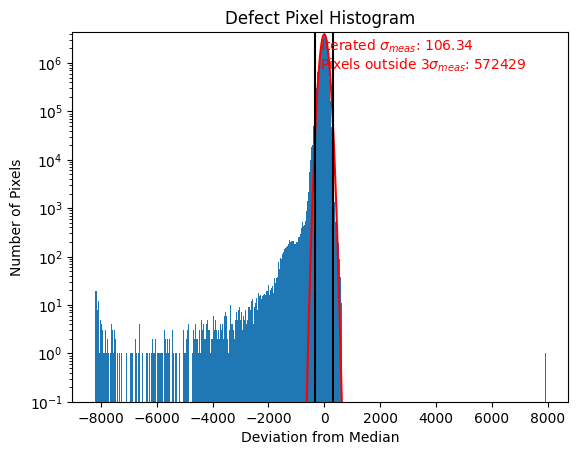

Number of NaNs in cleanArray: 572429


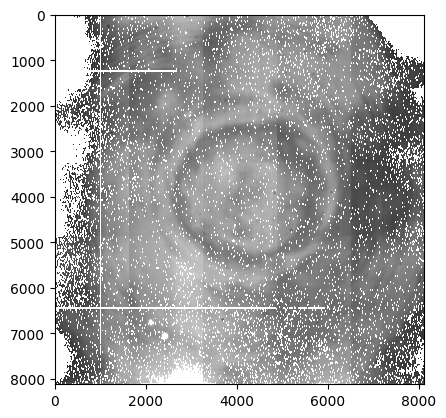

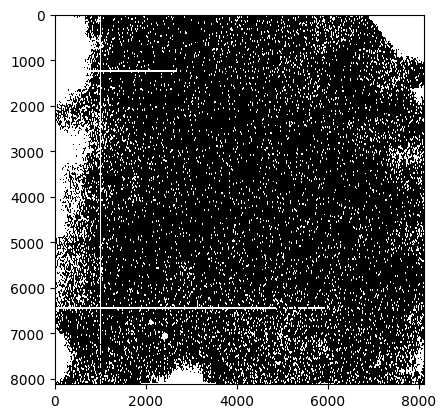

In [70]:
sigma_level = 3
plot_defect_hist(medStackGray, sigma_level=sigma_level, num_bins=1024)
defectMapGray, stdGray = defect_pix_map(medStackGray, sigma_level=sigma_level)
cleanArrayGray = medStackGray * defectMapGray
# count NaNs in cleanArray
nanCount = np.count_nonzero(np.isnan(cleanArrayGray))
print(f'Number of NaNs in cleanArray: {nanCount}')
plt.imshow(cleanArrayGray, cmap='gray')
plt.show()
plt.imshow(defectMapGray, cmap='gray')
plt.show()

1879122


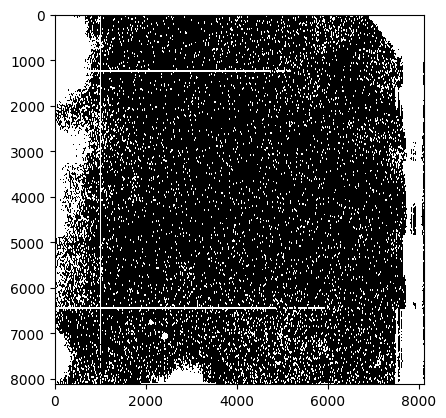

In [68]:
full_defect_map = defectMapDark * defectMapGray
nanCount = np.count_nonzero(np.isnan(full_defect_map))
print(nanCount)
plt.imshow(full_defect_map, cmap='gray')
plt.show()